In [58]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

In [59]:
def load_glove_embeddings(file_path, word_to_index, embedding_dim):
    embeddings = {}
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings[word] = coefs

    num_words = len(word_to_index)+1  # add 1 for the padding token
    embedding_matrix = np.zeros((num_words, embedding_dim))

    for word, index in word_to_index.items():
        if (embedding := embeddings.get(word)) is not None:
            embedding_matrix[index] = embedding
        else:
            embedding_matrix[index] = embeddings.get("<unk>", np.zeros(embedding_dim))

    return embedding_matrix

In [60]:
with open("processed_train_data.json", "r") as file:
    processed_train_data = json.load(file)
with open("processed_val_data.json", "r") as file:
    processed_val_data = json.load(file)
with open("processed_test_data.json", "r") as file:
    processed_test_data = json.load(file)

texts_train = [entry["text"] for entry in processed_train_data.values()]
labels_train = [entry["labels"] for entry in processed_train_data.values()]
texts_val = [entry["text"] for entry in processed_val_data.values()]
labels_val = [entry["labels"] for entry in processed_val_data.values()]
texts_test = [entry["text"] for entry in processed_val_data.values()]
labels_test = [entry["labels"] for entry in processed_val_data.values()]

In [61]:
word_to_index = {}
word_to_index["<unk>"] = 0
index = 1 
for entry in processed_train_data.values():
    tokens = entry["text"].split() 
    for token in tokens:
        if token not in word_to_index:
            word_to_index[token] = index
            index += 1

embedding_dim = 100
label_to_index = {"O": 0, "B": 1, "I": 2}

glove_embeddings_path = "../word_embeddings/glove.6B.100d.txt"  
embedding_matrix = load_glove_embeddings(glove_embeddings_path, word_to_index, embedding_dim)

In [62]:
x_train = [[word_to_index.get(token, word_to_index["<unk>"]) for token in text.split()] for text in texts_train]
y_train = [[label_to_index[label] for label in entry] for entry in labels_train] 
x_val = [[word_to_index.get(token, word_to_index["<unk>"]) for token in text.split()] for text in texts_val]
y_val = [[label_to_index[label] for label in entry] for entry in labels_val] 
x_test = [[word_to_index.get(token, word_to_index["<unk>"]) for token in text.split()] for text in texts_val]
y_test = [[label_to_index[label] for label in entry] for entry in labels_val]

In [63]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return torch.LongTensor(self.x[index]), torch.LongTensor(self.y[index])

In [64]:
def collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets = pad_sequence(targets, batch_first=True, padding_value=0)
    return inputs, targets

In [65]:
train_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)
test_dataset = CustomDataset(x_test, y_test)

In [66]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [67]:
class SimpleRNN(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), padding_idx=0)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        output = self.fc(output)
        return output

In [68]:
hidden_size = 100
output_size = len(label_to_index)
model = SimpleRNN(embedding_matrix, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15

In [69]:
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in range(num_epochs):
    model.train()
    all_train_preds = []
    all_train_targets = []

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, output_size), targets.view(-1))
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=2).cpu().numpy()
        targets = targets.cpu().numpy()

        all_train_preds.extend(preds)
        all_train_targets.extend(targets)

    train_macro_f1 = f1_score(np.concatenate(all_train_targets, axis=0), np.concatenate(all_train_preds, axis=0), average="macro")
    train_f1_scores.append(train_macro_f1)

    model.eval()
    all_val_preds = []
    all_val_targets = []

    with torch.no_grad():
        val_loss = 0.0
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, output_size), targets.view(-1))
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=2).cpu().numpy()
            targets = targets.cpu().numpy()

            all_val_preds.extend(preds)
            all_val_targets.extend(targets)

        val_loss /= len(val_loader)
        val_macro_f1 = f1_score(np.concatenate(all_val_targets, axis=0), np.concatenate(all_val_preds, axis=0), average="macro")
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        val_f1_scores.append(val_macro_f1)

        if epoch == num_epochs - 1:
            print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
            print(f"Validation Macro F1: {val_macro_f1:.4f}")
            print(f"Training Macro F1: {train_macro_f1:.4f}")

Epoch 15/15, Validation Loss: 0.0743
Validation Macro F1: 0.6866
Training Macro F1: 0.7091


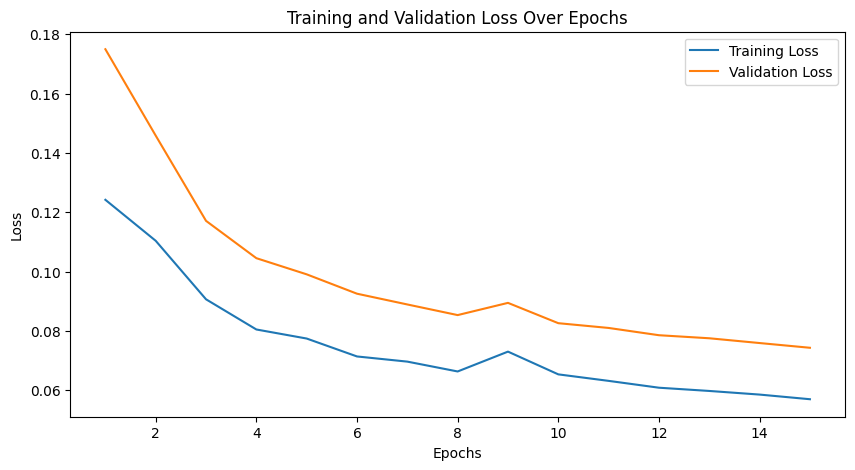

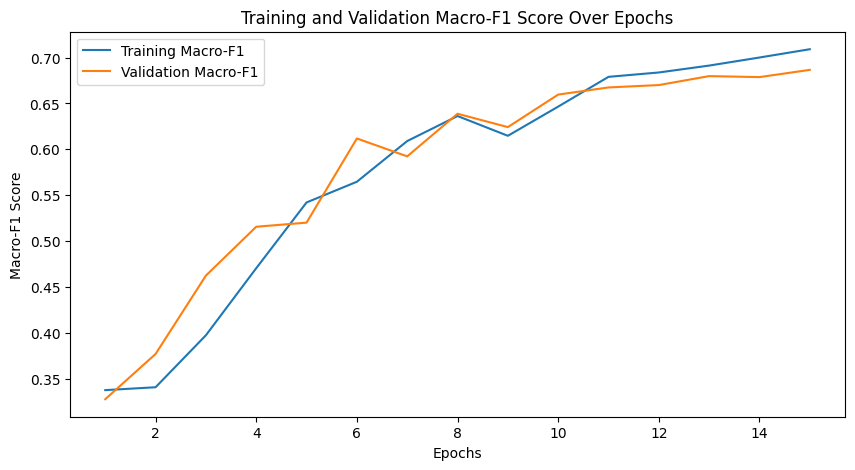

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.savefig("plots/rnn_glove_loss.png") 
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_f1_scores, label="Training Macro-F1")
plt.plot(range(1, num_epochs+1), val_f1_scores, label="Validation Macro-F1")
plt.xlabel("Epochs")
plt.ylabel("Macro-F1 Score")
plt.title("Training and Validation Macro-F1 Score Over Epochs")
plt.legend()
plt.savefig("plots/rnn_glove_macro.png") 
plt.show()
torch.save(model.state_dict(),"models/rnn_glove.pth")

In [71]:
model.eval()

all_preds_test = []
all_targets_test = []

with torch.no_grad():
    for inputs_test, targets_test in test_loader:
        outputs_test = model(inputs_test)
        preds_test = torch.argmax(outputs_test, dim=2).cpu().numpy()
        targets_test = targets_test.cpu().numpy()

        all_preds_test.extend(preds_test)
        all_targets_test.extend(targets_test)

all_preds_test = np.concatenate(all_preds_test, axis=0)
all_targets_test = np.concatenate(all_targets_test, axis=0)

test_accuracy = accuracy_score(all_targets_test, all_preds_test)
test_macro_f1 = f1_score(all_targets_test, all_preds_test, average="macro")

print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test Macro F1: {test_macro_f1:.4f}")


Final Test Accuracy: 0.9768
Final Test Macro F1: 0.6866
